# Bibliotecas

In [28]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import torch
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [29]:
device = 0 if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Base de Dados

## Real

In [31]:
import json

def generate_dataframe_from_jsonl(file_path):
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON line: {line.strip()}")
                    print(f"Error details: {e}")
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    return pd.DataFrame(data)

df_puns = generate_dataframe_from_jsonl(os.path.abspath('files\puns_real\puntuguese.jsonl'))
df_puns.rename(columns={'label': 'HUMOR','text' : 'TROCADILHO'}, inplace=True)
df_puns.drop(columns=['id', 'tokens', 'labels'], inplace=True)
df_puns.shape

(5700, 2)

## Sintético

In [32]:
def get_rows(df):
    # Convertendo as colunas de string pra lista
    df['pun_bin'] = df['pun_bin'].apply(eval)
    df['puns'] = df['puns'].apply(eval)
    df['analyses'] = df['analyses'].apply(eval)

    # Lista para armazenar os resultados
    linhas = []

    # Iterando sobre cada linha
    for _, row in df.iterrows():
        for pun_bin, pun, analyses in zip(row['pun_bin'], row['puns'], row['analyses']):
            linhas.append({'pun_bin': pun_bin, 'pun': pun, 'analyses': analyses, 'GRUPO': row['GRUPO']})

    # Criando novo DataFrame
    df_rows = pd.DataFrame(linhas)

    return df_rows

In [33]:
df_puns_sintetico_final = pd.read_excel(os.path.abspath(r'files\puns_sintetico\analiseTrocadilhos.xlsx'))
df_puns_sintetico_final['HUMOR_SABIA'] = df_puns_sintetico_final['pun_bin_sabia'].apply(lambda x: 1 if x=='SIM' else 0)
df_puns_sintetico_final['HUMOR_GPT'] = df_puns_sintetico_final['pun_bin_gpt'].apply(lambda x: 1 if x=='SIM' else 0)
df_puns_sintetico_final['HUMOR_HUMAN'] = df_puns_sintetico_final['pun_bin_human'].apply(lambda x: 1 if x=='SIM' else 0)

df_puns_sintetico_final['pun_style_human'] = df_puns_sintetico_final['pun_style_human'].replace('TROCADILHO HOMOGRÁFICO', 'TROCADILHO HOMOGRAFICO')

df_puns_sintetico_final = df_puns_sintetico_final.groupby('GRUPO').head(100)
df_puns_sintetico_final.rename(columns={'puns': 'TROCADILHO'}, inplace=True)
df_puns_sintetico_final.shape

(600, 14)

# Reconhecimento de Trocadilhos com pun-recognition-pt

In [34]:
model_name = 'Superar/pun-recognition-pt'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

prediction = classifier(df_puns_sintetico_final['TROCADILHO'].to_list())
pred_df = pd.DataFrame(prediction)
pred_df['label'] = pred_df['label'].str[-1].astype(int)

y_true = df_puns_sintetico_final['HUMOR_HUMAN']
y_pred = pred_df['label']
print(classification_report(y_true, y_pred))

# Extrai os valores de label e score de cada predição
df_puns_sintetico_final['PREDICT_LABEL'] = [item['label'] for item in prediction]
df_puns_sintetico_final['PREDICT_SCORE'] = [item['score'] for item in prediction]

df_puns_sintetico_final['HUMOR_PT_RECOGNITION'] = df_puns_sintetico_final['PREDICT_LABEL'].apply(lambda x: 1 if x=='LABEL_1' else 0)

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       559
           1       0.01      0.02      0.02        41

    accuracy                           0.81       600
   macro avg       0.47      0.45      0.46       600
weighted avg       0.86      0.81      0.84       600



# Análise da Geração

In [35]:
# Porcentagem de trocadilhos gerados
print(df_puns_sintetico_final.pun_style_human.value_counts().sum() / df_puns_sintetico_final.shape[0] * 100)

# Porcentagem do tipo de trocadilhos gerados
print(df_puns_sintetico_final.pun_style_human.value_counts(True)*100)

6.833333333333333
pun_style_human
TROCADILHO HOMOGRAFICO      92.682927
TROCADILHO HETEROGRAFICO     7.317073
Name: proportion, dtype: float64


# Análise de Reconhecimento

0.17
0.11702127659574468
1.0
0.2095238095238095


<Figure size 600x400 with 0 Axes>

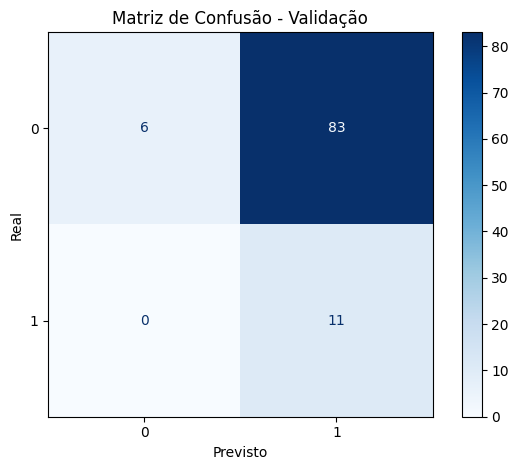

In [36]:
label_1 = df_puns_sintetico_final[df_puns_sintetico_final['GRUPO']=='TROCADILHO_gpt-4.1_zero_shot.csv']['HUMOR_HUMAN']
label_2 = df_puns_sintetico_final[df_puns_sintetico_final['GRUPO']=='TROCADILHO_gpt-4.1_zero_shot.csv']['HUMOR_SABIA']

print(accuracy_score(label_1, label_2))
print(precision_score(label_1, label_2))
print(recall_score(label_1, label_2))
print(f1_score(label_1, label_2))

cm = confusion_matrix(label_1, label_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# 🎨 Plotar
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Validação")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [37]:
# Criar coluna binária para PREDICT_LABEL
df_puns_sintetico_final['PREDICT_LABEL_BIN'] = df_puns_sintetico_final['PREDICT_LABEL'].map({'LABEL_0': 0, 'LABEL_1': 1})
col_humor = 'HUMOR_GPT'
col_pun_bin = 'pun_bin_gpt'

# ---------------------------
# 1. PORCENTAGEM DE HUMOR POR GRUPO
# ---------------------------
# Agrupar por GRUPO e score
grouped_humor = df_puns_sintetico_final.groupby(['GRUPO', col_pun_bin]).agg({col_humor: 'count'}).reset_index()

# Separar score == 0 e score > 0
score_0 = grouped_humor[grouped_humor[col_pun_bin] == 'NÃO'].groupby('GRUPO')[col_humor].sum()
score_maior_0 = grouped_humor[grouped_humor[col_pun_bin] == 'SIM'].groupby('GRUPO')[col_humor].sum()
score_total = grouped_humor.groupby('GRUPO')[col_humor].sum()

# Calcular porcentagens
percent_0 = (score_0 / score_total * 100).round(2)
percent_maior_0 = (score_maior_0 / score_total * 100).round(2)

df_percent_humor = pd.DataFrame({
    '%_score_0': percent_0,
    '%_score_maior_0': percent_maior_0
}).fillna(0)

print(f"📌 Porcentagem de {col_humor} por grupo:")
print(df_percent_humor)

# ---------------------------
# 2. PORCENTAGEM DE PREDICT_LABEL POR GRUPO
# ---------------------------
predict_counts = df_puns_sintetico_final.groupby(['GRUPO', 'PREDICT_LABEL'])[col_humor].count().unstack(fill_value=0)
predict_percent = (predict_counts.T / predict_counts.sum(axis=1)).T * 100

print("\n📌 Porcentagem de PREDICT_LABEL por grupo:")
print(predict_percent.round(2))

# ---------------------------
# 3. COMPARAÇÃO HUMOR vs PREDICT_LABEL_BIN
# ---------------------------
# Garantir binarização do label
df_puns_sintetico_final['PREDICT_LABEL_BIN'] = df_puns_sintetico_final['PREDICT_LABEL'].map({'LABEL_0': 0, 'LABEL_1': 1})

# Inicializar dicionário de resultados por grupo
resultados_por_grupo = {}

# Loop por GRUPO
for grupo, df_grupo in df_puns_sintetico_final.groupby('GRUPO'):
    total = len(df_grupo)
    casos = {
        '1 e LABEL_1': ((df_grupo[col_humor] == 1) & (df_grupo['HUMOR_HUMAN'] == 1)).sum(),
        '0 e LABEL_0': ((df_grupo[col_humor] == 0) & (df_grupo['HUMOR_HUMAN'] == 0)).sum(),
        '1 e LABEL_0': ((df_grupo[col_humor] == 1) & (df_grupo['HUMOR_HUMAN'] == 0)).sum(),
        '0 e LABEL_1': ((df_grupo[col_humor] == 0) & (df_grupo['HUMOR_HUMAN'] == 1)).sum(),
    }
    porcentagens = {k: round(v / total * 100, 2) for k, v in casos.items()}
    resultados_por_grupo[grupo] = porcentagens

# Exibir resultados
print(f"\n📌 Distribuição entre {col_humor} e HUMOR_HUMAN por GRUPO:")
for grupo, dist in resultados_por_grupo.items():
    print(f"\n🔹 {grupo}:")
    for caso, perc in dist.items():
        print(f"{caso}: {perc}%")

📌 Porcentagem de HUMOR_GPT por grupo:
                                           %_score_0  %_score_maior_0
GRUPO                                                                
TROCADILHO_gpt-4.1_chain-of-thought.csv         46.0             54.0
TROCADILHO_gpt-4.1_few_shot.csv                 43.0             57.0
TROCADILHO_gpt-4.1_zero_shot.csv                52.0             48.0
TROCADILHO_sabia-3.1_chain-of-thought.csv       44.0             56.0
TROCADILHO_sabia-3.1_few_shot.csv               47.0             53.0
TROCADILHO_sabia-3.1_zero_shot.csv              45.0             55.0

📌 Porcentagem de PREDICT_LABEL por grupo:
PREDICT_LABEL                              LABEL_0  LABEL_1
GRUPO                                                      
TROCADILHO_gpt-4.1_chain-of-thought.csv       94.0      6.0
TROCADILHO_gpt-4.1_few_shot.csv               82.0     18.0
TROCADILHO_gpt-4.1_zero_shot.csv              98.0      2.0
TROCADILHO_sabia-3.1_chain-of-thought.csv     89.0     11.0

# Reconhecimento de Trocadilhos Sintéticos

In [ ]:
# Carregar Trocadilhos sintéticos para base de treinamento
df_trocadilhos_bert_training = (
    pd.read_excel(os.path.abspath(r'files\puns_sintetico\analiseTrocadilho_2.xlsx'))
    .groupby('GRUPO', group_keys=False)
    .head(100)
    .rename(columns={'puns': 'TROCADILHO'})
    .assign(
        HUMOR_HUMAN=lambda df: df['pun_bin_human'].eq('SIM').astype(int),
        ORIGEM_HUMOR='SINTETICO'
    )
)

# Mantém apenas trocadilhos humanos positivos
df_trocadilhos_bert_training = df_trocadilhos_bert_training.loc[df_trocadilhos_bert_training['HUMOR_HUMAN'] == 1, ['TROCADILHO', 'ORIGEM_HUMOR']]

# Anotar origem dos dados
df_puns['ORIGEM_HUMOR'] = 'HUMANO'
df_puns_sintetico_final['ORIGEM_HUMOR'] = 'SINTETICO'

# Criar base de validação 
df_modelo_validacao_final = pd.concat([
    df_puns_sintetico_final.loc[df_puns_sintetico_final['HUMOR_HUMAN'] == 1, ['ORIGEM_HUMOR', 'TROCADILHO']],
    df_puns.loc[(df_puns['ORIGEM_HUMOR'] == 'HUMANO') & (df_puns['HUMOR'] == 1), ['TROCADILHO', 'ORIGEM_HUMOR']].iloc[106:147]
], ignore_index=True)

# Criar base para treinamento do modelo
num_data_humano, num_data_sintetico = 105, 35
df_modelo = pd.concat([
    df_puns.loc[(df_puns['HUMOR'] == 1) & (df_puns['ORIGEM_HUMOR'] == 'HUMANO'), ['ORIGEM_HUMOR', 'TROCADILHO']].head(num_data_humano),
    df_trocadilhos_bert_training.head(num_data_sintetico)
], ignore_index=True)

# Embaralhar e salvar
df_modelo = shuffle(df_modelo, random_state=42).reset_index(drop=True)
df_modelo.to_csv('data_modelo.csv', index=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\vinic\.virtualenvs\trocadilhos-rGqvvaSL\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  6%|▌         | 11/180 [00:02<00:25,  6.64it/s]

{'loss': 0.495, 'grad_norm': 3.658811092376709, 'learning_rate': 4.722222222222222e-05, 'epoch': 0.56}


 10%|█         | 18/180 [00:03<00:22,  7.33it/s]c:\Users\vinic\.virtualenvs\trocadilhos-rGqvvaSL\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 10%|█         | 18/180 [00:03<00:22,  7.33it/s]

{'eval_loss': 0.850555419921875, 'eval_accuracy': 0.5, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.395, 'eval_samples_per_second': 207.602, 'eval_steps_per_second': 27.849, 'epoch': 1.0}


 12%|█▏        | 21/180 [00:07<01:43,  1.54it/s]

{'loss': 0.6459, 'grad_norm': 7.087249755859375, 'learning_rate': 4.4444444444444447e-05, 'epoch': 1.11}


 17%|█▋        | 31/180 [00:08<00:24,  6.08it/s]

{'loss': 0.5628, 'grad_norm': 11.277397155761719, 'learning_rate': 4.166666666666667e-05, 'epoch': 1.67}


 20%|██        | 36/180 [00:09<00:20,  7.02it/s]c:\Users\vinic\.virtualenvs\trocadilhos-rGqvvaSL\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 20%|██        | 36/180 [00:09<00:20,  7.02it/s]

{'eval_loss': 0.9479244351387024, 'eval_accuracy': 0.5, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.4096, 'eval_samples_per_second': 200.172, 'eval_steps_per_second': 26.852, 'epoch': 2.0}


 23%|██▎       | 41/180 [00:13<00:52,  2.65it/s]

{'loss': 0.4848, 'grad_norm': 3.8759360313415527, 'learning_rate': 3.888888888888889e-05, 'epoch': 2.22}


 28%|██▊       | 51/180 [00:14<00:20,  6.15it/s]

{'loss': 0.3747, 'grad_norm': 8.195944786071777, 'learning_rate': 3.611111111111111e-05, 'epoch': 2.78}


                                                
 30%|███       | 54/180 [00:15<00:19,  6.55it/s]

{'eval_loss': 1.1500505208969116, 'eval_accuracy': 0.6341463414634146, 'eval_f1': 0.4444444444444444, 'eval_precision': 0.9230769230769231, 'eval_recall': 0.2926829268292683, 'eval_runtime': 0.4057, 'eval_samples_per_second': 202.132, 'eval_steps_per_second': 27.115, 'epoch': 3.0}


 34%|███▍      | 61/180 [00:19<00:31,  3.77it/s]

{'loss': 0.3978, 'grad_norm': 12.667213439941406, 'learning_rate': 3.3333333333333335e-05, 'epoch': 3.33}


 39%|███▉      | 71/180 [00:20<00:17,  6.12it/s]

{'loss': 0.264, 'grad_norm': 0.9230342507362366, 'learning_rate': 3.055555555555556e-05, 'epoch': 3.89}


                                                
 40%|████      | 72/180 [00:21<00:16,  6.64it/s]

{'eval_loss': 0.6860498785972595, 'eval_accuracy': 0.7682926829268293, 'eval_f1': 0.7246376811594203, 'eval_precision': 0.8928571428571429, 'eval_recall': 0.6097560975609756, 'eval_runtime': 0.4024, 'eval_samples_per_second': 203.801, 'eval_steps_per_second': 27.339, 'epoch': 4.0}


 45%|████▌     | 81/180 [00:25<00:20,  4.92it/s]

{'loss': 0.1373, 'grad_norm': 0.11399280279874802, 'learning_rate': 2.777777777777778e-05, 'epoch': 4.44}


 50%|█████     | 90/180 [00:26<00:12,  6.93it/s]

{'loss': 0.005, 'grad_norm': 0.07701773941516876, 'learning_rate': 2.5e-05, 'epoch': 5.0}


                                                
 50%|█████     | 90/180 [00:27<00:12,  6.93it/s]

{'eval_loss': 0.8350403308868408, 'eval_accuracy': 0.8414634146341463, 'eval_f1': 0.8266666666666665, 'eval_precision': 0.9117647058823529, 'eval_recall': 0.7560975609756098, 'eval_runtime': 0.35, 'eval_samples_per_second': 234.297, 'eval_steps_per_second': 31.43, 'epoch': 5.0}


 56%|█████▌    | 101/180 [00:43<00:21,  3.67it/s]

{'loss': 0.1532, 'grad_norm': 0.07499808073043823, 'learning_rate': 2.2222222222222223e-05, 'epoch': 5.56}


                                                 
 60%|██████    | 108/180 [00:45<00:10,  6.88it/s]

{'eval_loss': 1.6117494106292725, 'eval_accuracy': 0.7439024390243902, 'eval_f1': 0.6557377049180327, 'eval_precision': 1.0, 'eval_recall': 0.4878048780487805, 'eval_runtime': 0.3744, 'eval_samples_per_second': 219.011, 'eval_steps_per_second': 29.379, 'epoch': 6.0}


 62%|██████▏   | 111/180 [00:47<00:33,  2.07it/s]

{'loss': 0.0699, 'grad_norm': 0.05316789820790291, 'learning_rate': 1.9444444444444445e-05, 'epoch': 6.11}


 67%|██████▋   | 121/180 [00:48<00:08,  6.89it/s]

{'loss': 0.0014, 'grad_norm': 0.027818182483315468, 'learning_rate': 1.6666666666666667e-05, 'epoch': 6.67}


                                                 
 70%|███████   | 126/180 [00:49<00:07,  7.64it/s]

{'eval_loss': 1.1268984079360962, 'eval_accuracy': 0.8170731707317073, 'eval_f1': 0.7761194029850745, 'eval_precision': 1.0, 'eval_recall': 0.6341463414634146, 'eval_runtime': 0.359, 'eval_samples_per_second': 228.403, 'eval_steps_per_second': 30.639, 'epoch': 7.0}


 73%|███████▎  | 131/180 [00:52<00:16,  2.95it/s]

{'loss': 0.0012, 'grad_norm': 0.0246729739010334, 'learning_rate': 1.388888888888889e-05, 'epoch': 7.22}


 78%|███████▊  | 141/180 [00:54<00:06,  6.45it/s]

{'loss': 0.001, 'grad_norm': 0.021047523245215416, 'learning_rate': 1.1111111111111112e-05, 'epoch': 7.78}


                                                 
 80%|████████  | 144/180 [00:55<00:05,  6.83it/s]

{'eval_loss': 1.2770308256149292, 'eval_accuracy': 0.8170731707317073, 'eval_f1': 0.7761194029850745, 'eval_precision': 1.0, 'eval_recall': 0.6341463414634146, 'eval_runtime': 0.411, 'eval_samples_per_second': 199.535, 'eval_steps_per_second': 26.767, 'epoch': 8.0}


 84%|████████▍ | 151/180 [00:58<00:06,  4.36it/s]

{'loss': 0.0009, 'grad_norm': 0.019964726641774178, 'learning_rate': 8.333333333333334e-06, 'epoch': 8.33}


 89%|████████▉ | 161/180 [00:59<00:02,  6.51it/s]

{'loss': 0.0008, 'grad_norm': 0.022443505004048347, 'learning_rate': 5.555555555555556e-06, 'epoch': 8.89}


                                                 
 90%|█████████ | 162/180 [01:00<00:02,  7.03it/s]

{'eval_loss': 1.3162139654159546, 'eval_accuracy': 0.8170731707317073, 'eval_f1': 0.7761194029850745, 'eval_precision': 1.0, 'eval_recall': 0.6341463414634146, 'eval_runtime': 0.3826, 'eval_samples_per_second': 214.311, 'eval_steps_per_second': 28.749, 'epoch': 9.0}


 95%|█████████▌| 171/180 [01:03<00:01,  5.46it/s]

{'loss': 0.0008, 'grad_norm': 0.019283678382635117, 'learning_rate': 2.777777777777778e-06, 'epoch': 9.44}


100%|██████████| 180/180 [01:04<00:00,  7.07it/s]

{'loss': 0.0007, 'grad_norm': 0.016737494617700577, 'learning_rate': 0.0, 'epoch': 10.0}


                                                 
100%|██████████| 180/180 [01:07<00:00,  7.07it/s]

{'eval_loss': 1.3236857652664185, 'eval_accuracy': 0.8170731707317073, 'eval_f1': 0.7761194029850745, 'eval_precision': 1.0, 'eval_recall': 0.6341463414634146, 'eval_runtime': 0.4557, 'eval_samples_per_second': 179.957, 'eval_steps_per_second': 24.141, 'epoch': 10.0}


100%|██████████| 180/180 [01:14<00:00,  7.07it/s]

{'train_runtime': 74.8148, 'train_samples_per_second': 18.713, 'train_steps_per_second': 2.406, 'train_loss': 0.1998354881044684, 'epoch': 10.0}


100%|██████████| 11/11 [00:00<00:00, 36.35it/s]


📈 Métricas de Validação Final:
eval_loss: 0.8350
eval_accuracy: 0.8415
eval_f1: 0.8267
eval_precision: 0.9118
eval_recall: 0.7561
eval_runtime: 0.3395
eval_samples_per_second: 241.5540
eval_steps_per_second: 32.4040
epoch: 10.0000


100%|██████████| 11/11 [00:00<00:00, 36.94it/s]


<Figure size 600x400 with 0 Axes>

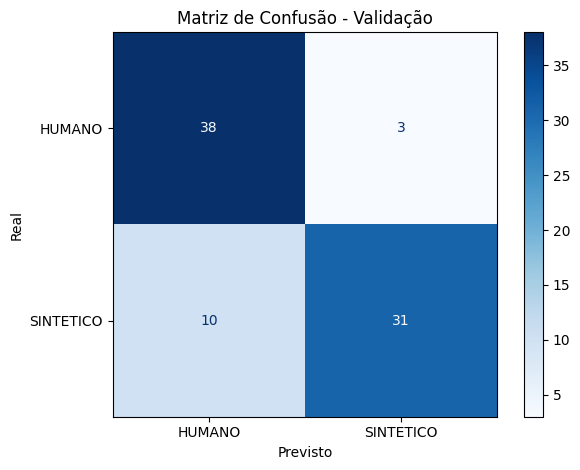

Classe prevista: SINTETICO


In [ ]:
# Codificando os rótulos
label_encoder = LabelEncoder()

train_texts = df_modelo['TROCADILHO'].tolist()
train_labels = label_encoder.fit_transform(df_modelo["ORIGEM_HUMOR"])
val_texts = df_modelo_validacao_final['TROCADILHO'].tolist()
val_labels = label_encoder.transform(df_modelo_validacao_final['ORIGEM_HUMOR']).tolist()

# Tokenizador
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class JokeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = JokeDataset(train_encodings, train_labels)
val_dataset = JokeDataset(val_encodings, val_labels)

# Modelo BERT com 2 classes
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)  # ✅ Move o modelo explicitamente para a GPU

# ⚙️ Argumentos de treino
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    report_to="none",  # Evita integração com W&B ou TensorBoard, opcional
)

# 📈 Métricas
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds)
    }

# 🏋️‍♂️ Trainer (cuida de tudo: GPU, batches, avaliação, etc.)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 🚀 Treinamento
trainer.train()

# 📊 Avaliação final no conjunto de validação
metrics = trainer.evaluate()
print("📈 Métricas de Validação Final:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# 🔍 Obter previsões no conjunto de validação
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# 📊 Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# 🎨 Plotar
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Validação")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

test_text = 'Por que o lápis não pode ser detetive? Sem ponta.'
inputs = tokenizer(test_text, return_tensors="pt", truncation=True, padding=True).to(device)
outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
pred = torch.argmax(probs).item()

print("Classe prevista:", label_encoder.inverse_transform([pred])[0])